In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa

In [2]:
%matplotlib inline
# %matplotlib qt

In [3]:
# from here https://stackoverflow.com/a/16445006/4999991
def polarToRectangular(radii, angles):
    return radii * np.exp(1j * angles)

In [4]:
def sortZip(x, y):
    order = np.argsort(x)
    xs = np.array(x)[order]
    ys = np.array(y)[order]
    return xs, ys

In [5]:
def plotSort(x, y):
    xs, ys = sortZip(x, y)
    plt.plot(xs, ys)

In [6]:
def frequencyGenerator(time, steps=None):
    𝛿 = time.max() - time.min()
    if steps is None:
        steps = np.diff(time).min()
    M = np.arange(1, steps + 1)
    return M / 𝛿, steps

In [7]:
def easyFourierTransform(time, signal, frequency=None, steps=None, sorted=False, uniform=False):
    if sorted:
        ts = time
        Xs = signal
    else:
        ts, Xs = sortZip(time, signal)
    
    if frequency is None:
        frequency, steps = frequencyGenerator(ts, steps)
    else:
        steps = frequency.shape[0]
    
    if uniform:
        N = signal.shape[0]
        amplitude = np.abs(scipy.fftpack.fft(signal)[:steps]) * 2.0 / N
    else:
        ft = frequency[:, np.newaxis]
        𝜃 = (ts - ts.min()) * 2 * np.pi * ft
        Y = polarToRectangular(Xs, 𝜃)[:, 1:] * np.diff(ts)
        amplitude = np.abs(Y.sum(axis=1))
    return frequency, amplitude

In [37]:
def easyFourierTransformThreshold(time, signal, frequency=None, steps=None, sorted=False, uniform=False):
    
    threshold = 0.05
    if sorted:
        ts = time
        Xs = signal
    else:
        ts, Xs = sortZip(time, signal)
    
    if frequency is None:
        frequency, steps = frequencyGenerator(ts, steps)
    else:
        steps = frequency.shape[0]
    
    if uniform:
        N = signal.shape[0]
        amplitude = np.abs(scipy.fftpack.fft(signal)[:steps]) * 2.0 / N
    else:
        ft = frequency[:, np.newaxis]
        𝜃 = (ts - ts.min()) * 2 * np.pi * ft
        Y = polarToRectangular(Xs, 𝜃)[:, 1:] * np.diff(ts)
        amplitude = np.abs(Y.sum(axis=1))
        threshold = amplitude[np.argsort(amplitude)[-5:]].mean()
        for i in range(len(amplitude)):
            if amplitude[i] < threshold:
                amplitude[i] = 0
    return frequency, amplitude

data length: 16.08 seconds
[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


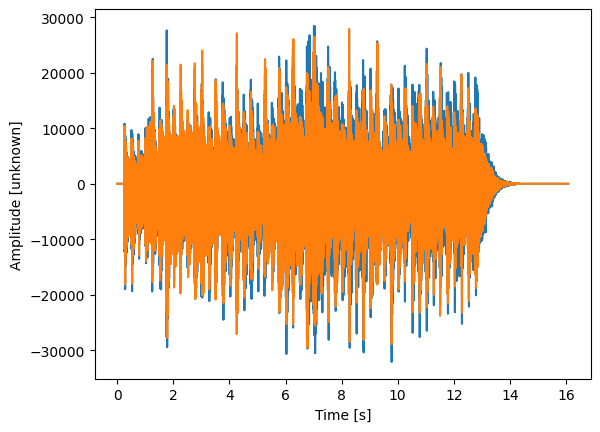

In [52]:
# Load the MP3 file
data_path = './brilliant-life-15sec.wav'
from scipy.io import wavfile

data, sample_rate = librosa.load(data_path)
rate, audio = wavfile.read(data_path)

# Convert the amplitude to floating point numbers
data = data.astype(np.float32)

#data = np.mean(data, axis=1)

N = audio.shape[0]
L = N / rate

print(f'data length: {L:.2f} seconds')

f, ax = plt.subplots()
ax.plot(np.arange(N) / rate, audio)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [unknown]');

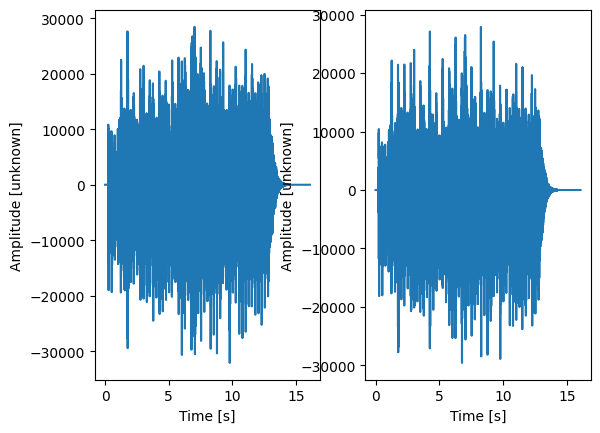

In [59]:
audio_left = np.array(audio)[:,0]
audio_right = np.array(audio)[:,1]

plt.subplot(1,2,1)
plt.plot(np.arange(N) / rate, audio_left)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [unknown]');

plt.subplot(1,2,2)
plt.plot(np.arange(N) / rate, audio_right)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [unknown]');

In [62]:
f_data, a_data = easyFourierTransformThreshold(np.arange(N) / rate, audio_left)

MemoryError: Unable to allocate 3.66 TiB for an array with shape (1, 709127, 709127) and data type float64

In [14]:
from skimage import util

M = 1024

slices = util.view_as_windows(data, window_shape=(M,), step=100)
print(f'data shape: {data.shape}, Sliced data shape: {slices.shape}')

data shape: (2913750,), Sliced data shape: (29128, 1024)


In [15]:
win = np.hanning(M + 1)[:-1]
slices = slices * win
slices = slices.T
print('Shape of `slices`:', slices.shape)
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

Shape of `slices`: (1024, 29128)


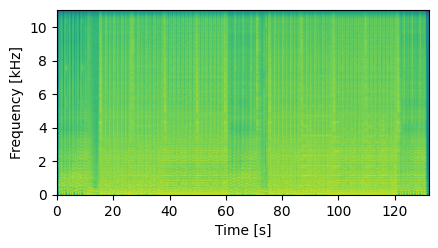

In [16]:
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, sample_rate / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

C:\Users\varun\AppData\Local\Temp\ipykernel_22312\2024590858.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')


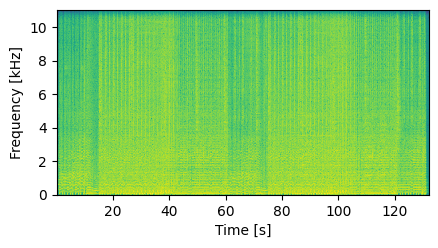

In [18]:
from scipy import signal

freqs, times, Sx = signal.spectrogram(data, fs=sample_rate, window='hann',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

C:\Users\varun\AppData\Local\Temp\ipykernel_22312\275470076.py:32: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax0.stem(lengths, np.array(exec_times) * 10**6, use_line_collection = True)
C:\Users\varun\AppData\Local\Temp\ipykernel_22312\275470076.py:35: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(lengths, smoothness, use_line_collection = True)


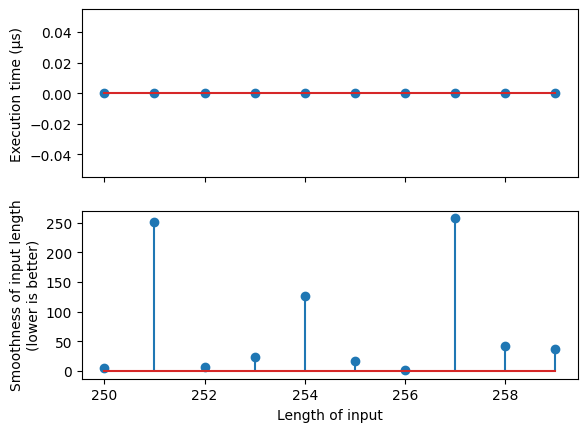

In [19]:
import time

from scipy import fftpack
from sympy import factorint

K = 1000
lengths = range(250, 260)

# Calculate the smoothness for all input lengths
smoothness = [max(factorint(i).keys()) for i in lengths]


exec_times = []
for i in lengths:
    z = np.random.random(i)

    # For each input length i, execute the FFT K times
    # and store the execution time

    times = []
    for k in range(K):
        tic = time.monotonic()
        fftpack.fft(z)
        toc = time.monotonic()
        times.append(toc - tic)

    # For each input length, remember the *minimum* execution time
    exec_times.append(min(times))


f, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
ax0.stem(lengths, np.array(exec_times) * 10**6, use_line_collection = True)
ax0.set_ylabel('Execution time (µs)')

ax1.stem(lengths, smoothness, use_line_collection = True)
ax1.set_ylabel('Smoothness of input length\n(lower is better)')
ax1.set_xlabel('Length of input');

In [21]:
from IPython.display import Audio
Audio(data_path)